In [202]:
from sentence_transformers import SentenceTransformer
from sklearn.svm import SVC
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from xgboost import XGBClassifier
import numpy as np

In [203]:
num_folds = 6
seed = 1
model_architecture = SVC #XGBClassifier 
model_kwargs = {}

In [204]:
unusable_columns = ['Use-cases', 'Categories', 'S No']
target_column = 'Type'
text_column = 'Prompts'

In [205]:
embedding_save_dir: str = 'src/data/extra/'
embedding_filename: str = 'embeddings_english'

In [206]:

data = pd.read_excel('src/data/extra/Turn 1 (HF).xlsx').drop(columns=unusable_columns)
label_encoder = LabelEncoder()
data[target_column] = label_encoder.fit_transform(data[target_column])


In [207]:
try:
    vectorized_data = np.load(embedding_save_dir + embedding_filename+'.npy')
except Exception as err:
    embedder = SentenceTransformer('jinaai/jina-embeddings-v2-base-en', trust_remote_code=True)
    embedder.max_seq_length = 4096
    vectorized_data = embedder.encode(data[text_column].tolist(), batch_size=4)
    np.save(embedding_save_dir+embedding_filename, vectorized_data)
    print(vectorized_data.shape)


In [208]:
splitter = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
folds = list(splitter.split(data[text_column], data[target_column]))

In [209]:
models = []
accuracies = []
oof_predictions = []
true_labels = []
for num_fold, (train_idx, test_idx) in enumerate(folds):
    train_data = data.loc[train_idx]
    test_data = data.loc[test_idx]
    train_vectors = vectorized_data[train_idx]
    test_vectors = vectorized_data[test_idx]
    model = model_architecture(**model_kwargs)
    model.fit(train_vectors, train_data[target_column])
    predictions = model.predict(test_vectors)
    accuracy = accuracy_score(test_data[target_column], predictions)
    models.append(model)
    oof_predictions.append(predictions)
    true_labels.append(test_data[target_column])
    accuracies.append(accuracy)
    print(f'Accuracy of fold {num_fold}: {accuracy}')
print(np.mean(accuracies))

Accuracy of fold 0: 0.79
Accuracy of fold 1: 0.84
Accuracy of fold 2: 0.8
Accuracy of fold 3: 0.87
Accuracy of fold 4: 0.78
Accuracy of fold 5: 0.83
0.8183333333333334


In [210]:
accuracies


[0.79, 0.84, 0.8, 0.87, 0.78, 0.83]

['Complex' 'Simple']


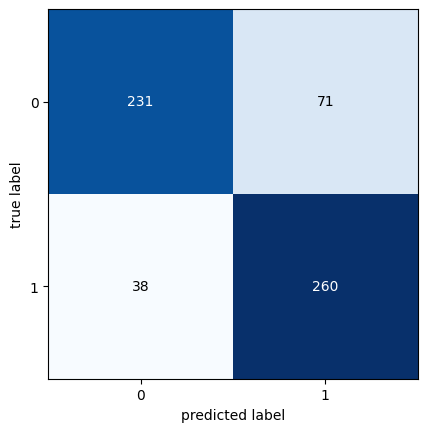

In [211]:
plot_confusion_matrix(confusion_matrix(np.concatenate(true_labels), np.concatenate(oof_predictions)))
print(label_encoder.inverse_transform([0, 1]))